In [1]:
%matplotlib widget

In [2]:
import torch, re
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [3]:
CONTEXT_SIZE = 2
EMBEDDING_DIM = 2

with open('data/book.txt', 'r', encoding='utf-8') as fp:
    test_sentence = fp.read().split()

In [4]:
ngrams = [
    (
        [test_sentence[i - j - 1] for j in range(CONTEXT_SIZE)],
        test_sentence[i]
    )
    for i in range(CONTEXT_SIZE, len(test_sentence))
]

ngrams[:3]

[(['back', 'hobbit'], 'hobbit'),
 (['hobbit', 'back'], 'tale'),
 (['tale', 'hobbit'], 'high')]

In [5]:
vocab = set(test_sentence)
word_to_ix = {word: i for i, word in enumerate(vocab)}

In [6]:
class NGramLanguageModeler(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramLanguageModeler, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs

In [7]:
losses = []
loss_function = nn.NLLLoss()
model = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE)
optimizer = optim.SGD(model.parameters(), lr=0.05)

In [8]:
for epoch in range(2):
    total_loss = 0
    for n, (contex, target) in enumerate(ngrams):
        contex_idxs = torch.tensor([word_to_ix[w] for w in contex], dtype=torch.long)

        model.zero_grad()
        preds = model(contex_idxs)
        loss = loss_function(preds, torch.tensor([word_to_ix[target]], dtype=torch.long))

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        print(f'[{n}/{len(ngrams)}] Current Word: {target+" "*20}', end='\r')
    print(f'Total Loss: {total_loss}, Epoch: {epoch}{" "*20}')
    losses.append(total_loss)

Total Loss: 2388267.9009227743, Epoch: 0                                                 
Total Loss: 2378073.854655981, Epoch: 1                                                  


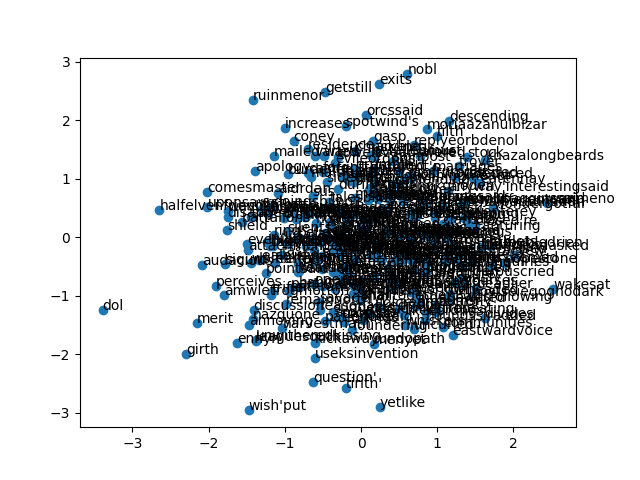

In [9]:
fig, ax = plt.subplots()
w2v = model.embeddings.weight.detach().numpy()[300:600]

# fig.set_figheight(12)
# fig.set_figwidth(14)
ax.scatter(w2v[:, 0], w2v[:, 1])

for word, num in list(word_to_ix.items())[300:600]:
    ax.annotate(word, w2v[num-300])

plt.show()